<a href="https://colab.research.google.com/github/sof1a03/DSS_groupproject/blob/main/RDW/RDW_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Basics
import os, re, math
import numpy as np
import pandas as pd

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.set_option("display.max_columns", 200)
sns.set(style="whitegrid")

# ---- Config ----
CSV = "df_cleaned_FINAL.csv"  # adjust if needed
YEAR_START, YEAR_END = 2023, 2025
YEARS = list(range(YEAR_START, YEAR_END+1))

# Load
df = pd.read_csv(CSV, low_memory=False)
print(df.shape)
df.head()

(3843, 20)


,brand,model,fuel_types_primary,resold_flag,inrichting_std,seats_median,mass_empty_median,length_median,width_median,wheelbase_median,pw_ratio_median,datum_eerste_toelating_year,count_2023,count_2024,count_2025,avg_2023,avg_2024,avg_2025,image_url_2,image_url_3
0,AUDI,Q4 45 e-tron,Elektriciteit,1,stationwagen,5.0,2135.0,459.0,187.0,277.0,0.000013,2024,105.0,2863.0,1243.0,67735.88,58893.60,57493.41,https://uploads.audi-mediacenter.com/system/pr...,https://uploads.audi-mediacenter.com/system/pr...
1,AUDI,Q2,"Benzine, Diesel",1,stationwagen,5.0,1280.0,421.0,180.0,259.0,0.000058,2023,1891.0,1848.0,940.0,45577.94,46148.48,48594.64,https://uploads.audi-mediacenter.com/system/pr...,https://uploads.audi-mediacenter.com/system/pr...
2,AUDI,A3 Sportback,"Benzine, Diesel, Elektriciteit",1,hatchback,5.0,1255.0,435.0,182.0,262.0,0.000044,2023,3012.0,1837.0,931.0,41083.76,42957.07,43886.43,https://uploads.audi-mediacenter.com/system/pr...,https://daisypstrg.blob.core.windows.net/vehic...
3,AUDI,A1 Sportback,"Benzine, Diesel",1,hatchback,5.0,1080.0,404.0,174.0,255.0,0.000053,2023,2128.0,1626.0,920.0,33815.98,33853.25,36263.14,https://uploads.audi-mediacenter.com/system/pr...,https://daisypstrg.blob.core.windows.net/vehic...
4,AUDI,Q6 Suv e-tron Performance,Elektriciteit,1,stationwagen,5.0,2175.0,477.0,195.0,290.0,0.000022,2025,0.0,329.0,520.0,NaN,82466.87,82587.72,https://media.audi.com/is/image/audi/nemo/mode...,https://uploads.audi-mediacenter.com/system/pr...


## Data typing + feature engineering

What & why:

Cast numeric columns to the right types.

Create avg_price (across available years).

Build a fuel bucket for high-level grouping.

Derive introduction year (first year a model appears) and share metrics used later (e.g., adoption growth).

In [2]:
# Ensure numeric
int_like = [*(f"count_{y}" for y in YEARS), "resold_flag", "datum_eerste_toelating_year"]
float_like = [*(f"avg_{y}" for y in YEARS),
              "seats_median","mass_empty_median","length_median","width_median","wheelbase_median","pw_ratio_median"]

for c in int_like:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce").astype("Int64")

for c in float_like:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Clean strings
for c in df.columns:
    if df[c].dtype == "object":
        df[c] = df[c].astype(str).str.strip().replace({"nan": np.nan, "None": np.nan})

# Convenience: average price across available years
df["avg_price"] = df[[c for c in df.columns if c.startswith("avg_")]].mean(axis=1, skipna=True)

# Fuel buckets (broad)
def fuel_bucket(s):
    s = (s or "").lower()
    if "elektriciteit" in s or "electric" in s or "ev" in s:
        return "EV"
    if "hybrid" in s or "e-hybrid" in s or "plug" in s:
        return "Hybrid/PHEV"
    if any(x in s for x in ["benzine","diesel","alcohol","lpg","cng"]):
        return "ICE"
    return "Other"

df["fuel_bucket"] = df["fuel_types_primary"].apply(fuel_bucket)

# Introduction year (first with positive count within window)
def intro_year(row, years=YEARS):
    for y in years:
        v = row.get(f"count_{y}")
        if pd.notna(v) and v > 0:
            return y
    y = row.get("datum_eerste_toelating_year")
    return int(y) if pd.notna(y) and y in years else np.nan

df["intro_year"] = df.apply(intro_year, axis=1)

# Shares & adoption growth
df["total_23_25"] = df[[f"count_{y}" for y in YEARS]].sum(axis=1)
df["share_2023"] = df["count_2023"] / df["total_23_25"].replace(0, np.nan)
df["share_2025"] = df["count_2025"] / df["total_23_25"].replace(0, np.nan)
df["share_delta"] = df["share_2025"] - df["share_2023"]

## Descriptive overview & missingness

What & why:

Get a quick picture of data quality and central tendencies.

This helps decide what features are usable and highlights potential biases.

In [3]:
# Missingness (top 15)
missing = df.isna().mean().sort_values(ascending=False)
print(missing.head(15))

# Summary numerics
desc_cols = [*float_like, *[c for c in int_like if c in df.columns], "avg_price"]
desc = df[desc_cols].describe().T
desc

avg_2025                       0.333854
avg_2023                       0.316680
avg_2024                       0.295342
length_median                  0.189956
width_median                   0.158730
fuel_types_primary             0.000000
inrichting_std                 0.000000
mass_empty_median              0.000000
model                          0.000000
resold_flag                    0.000000
brand                          0.000000
pw_ratio_median                0.000000
wheelbase_median               0.000000
seats_median                   0.000000
datum_eerste_toelating_year    0.000000
dtype: float64


,count,mean,std,min,25%,50%,75%,max
avg_2023,2626.0,74898.15107,86865.993851,1028.0,30644.375,50784.81,89445.0,1596565.67
avg_2024,2708.0,75934.253294,87979.302989,64.0,29615.135,52166.3,91958.4175,1337735.5
avg_2025,2560.0,76891.400223,110060.90911,1999.0,28092.5925,51185.835,87510.5825,2524436.0
seats_median,3843.0,3.979053,1.427865,1.0,2.0,4.0,5.0,9.0
mass_empty_median,3843.0,1722.674993,1030.271665,87.0,1167.0,1741.0,2485.0,19300.0
length_median,3113.0,474.344844,162.517085,171.0,420.0,472.0,566.0,1132.0
width_median,3233.0,178.108413,47.460886,67.0,177.0,188.0,205.0,255.0
wheelbase_median,3843.0,282.625943,86.545239,114.0,252.0,281.0,345.0,685.0
pw_ratio_median,3843.0,0.000291,0.000627,0.0,0.000015,0.000047,0.000102,0.004241
count_2023,3843.0,130.468124,698.242553,0.0,0.0,1.0,13.0,12209.0


## Distributions for classification-related columns

What & why:

Even if you’re not classifying yet, distributions of inrichting_std, seats, mass, length, wheelbase, power-to-weight tell you what ranges and modes exist and where cutoffs might make sense later.

,count
inrichting_std,
Niet geregistreerd,782
kampeerwagen,753
stationwagen,607
sedan,367
hatchback,344
MPV,255
coupe,204
cabriolet,190
gesloten opbouw,163


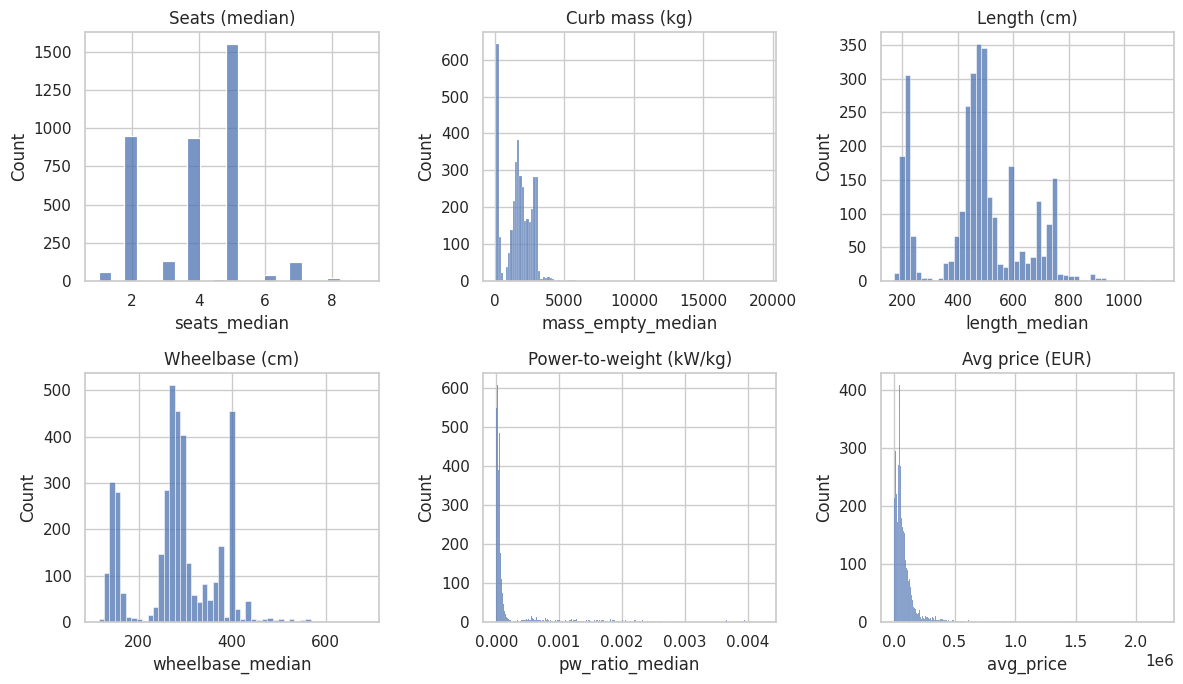

In [4]:
# Categorical preview
if "inrichting_std" in df.columns:
    display(df["inrichting_std"].value_counts(dropna=False).head(20))

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.ravel()
num_plots = [
    ("seats_median", "Seats (median)"),
    ("mass_empty_median", "Curb mass (kg)"),
    ("length_median", "Length (cm)"),
    ("wheelbase_median", "Wheelbase (cm)"),
    ("pw_ratio_median", "Power-to-weight (kW/kg)"),
    ("avg_price", "Avg price (EUR)"),
]
for ax, (col, title) in zip(axes, num_plots):
    if col in df.columns:
        sns.histplot(df[col], kde=False, ax=ax)
        ax.set_title(title)
plt.tight_layout(); plt.show()

## New vs continuing models per year

What & why:

Answers “are new models bought more than old models each year?”

We split volumes into models introduced that year vs continuing models.

In [5]:
volumes = []
for y in YEARS:
    new_mask = df["intro_year"] == y
    cont_mask = df["intro_year"].notna() & (df["intro_year"] < y)
    ccol = f"count_{y}"
    new_units = df.loc[new_mask, ccol].fillna(0).sum()
    cont_units = df.loc[cont_mask, ccol].fillna(0).sum()
    volumes.append({"year": y, "new_units": int(new_units), "continuing_units": int(cont_units)})

df_new_old = pd.DataFrame(volumes)
df_new_old["new_share"] = df_new_old["new_units"] / (df_new_old["new_units"] + df_new_old["continuing_units"]).replace(0, np.nan)
df_new_old


,year,new_units,continuing_units,new_share
0,2023,501389,0,1.000000
1,2024,19060,551323,0.033416
2,2025,8296,274543,0.029331


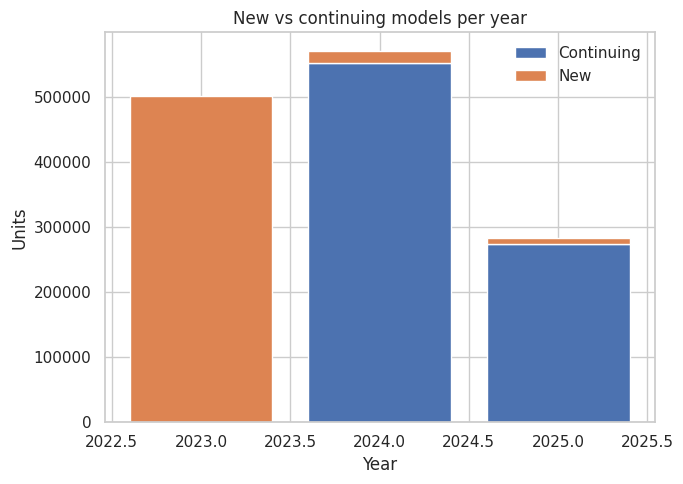

In [6]:
fig, ax = plt.subplots(figsize=(7,5))
ax.bar(df_new_old["year"], df_new_old["continuing_units"], label="Continuing")
ax.bar(df_new_old["year"], df_new_old["new_units"], bottom=df_new_old["continuing_units"], label="New")
ax.set_title("New vs continuing models per year")
ax.set_xlabel("Year"); ax.set_ylabel("Units"); ax.legend(frameon=False)
plt.tight_layout(); plt.show()

## Scatterplot: adoption growth vs average price

Why this is useful:

Tests whether higher-priced models can still gain share (market strength despite price) or if price suppresses growth.

We look at change in each model’s share of its own 2023–2025 volume vs its average price.

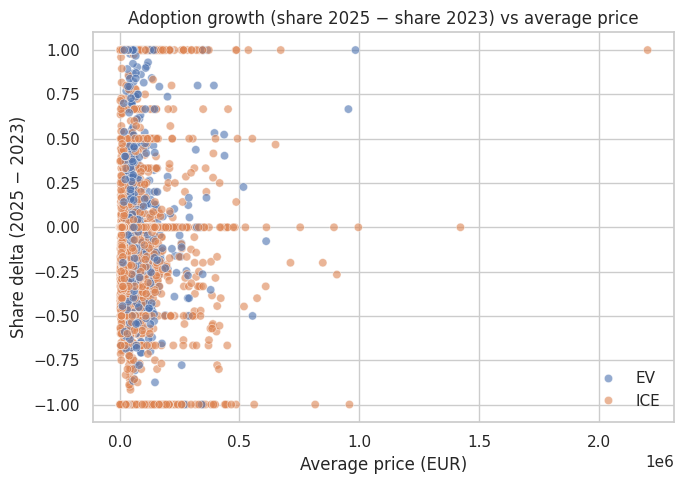

In [8]:
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x="avg_price", y="share_delta", hue="fuel_bucket", alpha=0.6)
plt.title("Adoption growth (share 2025 − share 2023) vs average price")
plt.xlabel("Average price (EUR)"); plt.ylabel("Share delta (2025 − 2023)")
plt.legend(frameon=False)
plt.tight_layout(); plt.show()

## Scatterplot: power-to-weight vs resold flag

Why this is useful:

Performance-oriented models (higher power-to-weight) could churn differently in the used market.

A visible separation hints at different life-cycle dynamics for “sporty/premium” models.

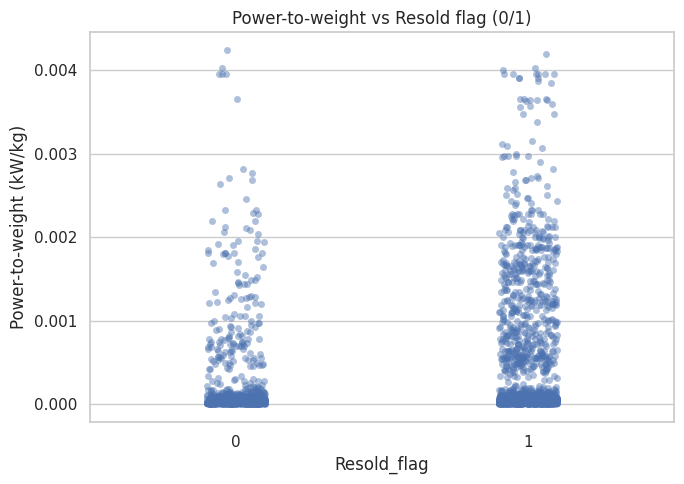

In [9]:
plt.figure(figsize=(7,5))
sns.stripplot(data=df, x="resold_flag", y="pw_ratio_median", jitter=True, alpha=0.45)
plt.title("Power-to-weight vs Resold flag (0/1)")
plt.xlabel("Resold_flag"); plt.ylabel("Power-to-weight (kW/kg)")
plt.tight_layout(); plt.show()

## Scatterplot: price percentile at introduction vs first-year success

Why this is useful:

For each model, compute price percentile within its introduction cohort, then compare to first-year success (units in intro year / total over 2023–2025).

Negative trend → premium pricing reduces early traction; flat/positive → strong brands can launch high.

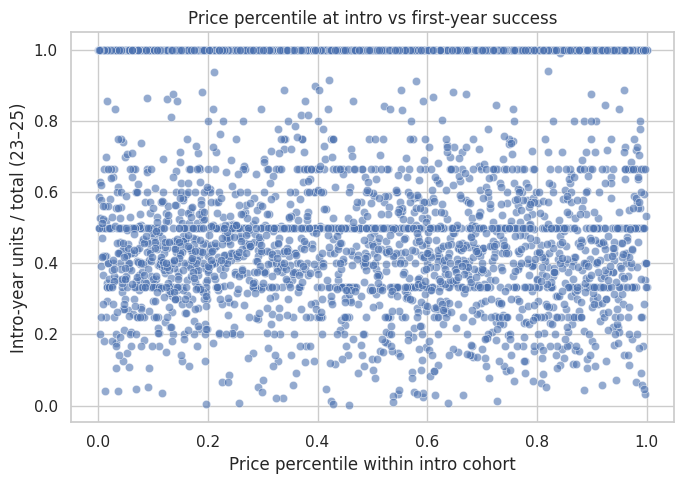

In [10]:
# Price percentile within intro cohort
df["intro_cohort"] = df["intro_year"]
df["first_year_success"] = np.nan
df["price_pct_in_cohort"] = np.nan

rows = []
for y, g in df.groupby("intro_cohort"):
    if g.empty or pd.isna(y):
        continue
    # percentile within cohort
    ranks = g["avg_price"].rank(pct=True)
    # first-year success ratio
    fy = f"count_{int(y)}"
    success = g[fy] / g[[f"count_{yy}" for yy in YEARS]].sum(axis=1).replace(0, np.nan)
    tmp = pd.DataFrame({"idx": g.index, "price_pct_in_cohort": ranks.values, "first_year_success": success.values})
    rows.append(tmp)

if rows:
    tmp = pd.concat(rows, ignore_index=True)
    df.loc[tmp["idx"], "price_pct_in_cohort"] = tmp["price_pct_in_cohort"].values
    df.loc[tmp["idx"], "first_year_success"] = tmp["first_year_success"].values

sub = df[["price_pct_in_cohort","first_year_success"]].dropna()
plt.figure(figsize=(7,5))
sns.scatterplot(data=sub, x="price_pct_in_cohort", y="first_year_success", alpha=0.6)
plt.title("Price percentile at intro vs first-year success")
plt.xlabel("Price percentile within intro cohort"); plt.ylabel("Intro-year units / total (23–25)")
plt.tight_layout(); plt.show()

## Brand concentration (HHI) per year

What & why:

HHI shows if a brand relies on a few hero models (high concentration) or has a balanced lineup.

Compare HHI across years and show brands with the biggest concentration change.

year,2023,2024,2025,delta_hhi_25_23
brand,,,,
LA STRADA,0.187500,0.159763,1.000000,0.812500
CADILLAC,0.125000,0.333333,0.360000,0.235000
ROLLS ROYCE,0.185185,0.645429,0.388430,0.203245
BENTLEY,0.046225,0.050851,0.138169,0.091944
NISSAN,0.306784,0.340765,0.385600,0.078816
MASH,0.148283,0.130194,0.215278,0.066994
GAS GAS,0.193878,0.167500,0.259259,0.065382
MUTT,0.142400,0.171875,0.206612,0.064212
SUZUKI,0.225572,0.236679,0.282261,0.056688


year,2023,2024,2025,delta_hhi_25_23
brand,,,,
LINCOLN,1.000000,0.333333,0.333333,-0.666667
BYD,0.682455,0.267239,0.217780,-0.464675
LOTUS,0.719822,0.715816,0.349490,-0.370332
ZERO MOTORCYCLES,0.506173,0.238367,0.163435,-0.342738
MAXUS,0.468052,0.298019,0.215302,-0.252750
MOBILVETTA DESIGN,0.382716,0.222222,0.142857,-0.239859
MORGAN,0.510204,0.408284,0.280000,-0.230204
MOTO GUZZI,0.504991,0.341172,0.298753,-0.206238
MV AGUSTA,0.388889,0.395000,0.204082,-0.184807


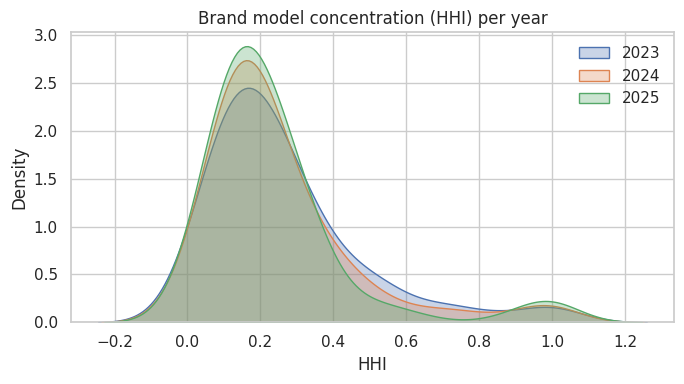

In [11]:
def hhi_from_counts(s):
    total = s.sum()
    if total <= 0:
        return np.nan
    shares = (s / total).values
    return np.sum(shares**2)

hhi_rows = []
for y in YEARS:
    c = f"count_{y}"
    tmp = df[[ "brand","model", c ]].dropna(subset=[c]).copy()
    for brand, g in tmp.groupby("brand"):
        hhi = hhi_from_counts(g[c])
        hhi_rows.append({"year": y, "brand": brand, "hhi": hhi})

hhi_df = pd.DataFrame(hhi_rows)
hhi_pivot = hhi_df.pivot(index="brand", columns="year", values="hhi")

if set(YEARS).issubset(hhi_pivot.columns):
    hhi_pivot["delta_hhi_25_23"] = hhi_pivot[2025] - hhi_pivot[2023]

# Show top increases/decreases in concentration
display(hhi_pivot.sort_values("delta_hhi_25_23", ascending=False).head(10))
display(hhi_pivot.sort_values("delta_hhi_25_23", ascending=True).head(10))

# Plot HHI distribution per year
plt.figure(figsize=(7,4))
for y in YEARS:
    sns.kdeplot(hhi_df.loc[hhi_df["year"]==y, "hhi"], label=str(y), fill=True, alpha=0.3)
plt.title("Brand model concentration (HHI) per year")
plt.xlabel("HHI"); plt.legend(frameon=False)
plt.tight_layout(); plt.show()

## Clustering (unsupervised segmentation)

What & why:

Discover natural segments (size/performance/price patterns) without imposing your future class rules.

Later, compare these clusters to your teammate’s class definitions.

In [12]:
features = ["mass_empty_median","length_median","wheelbase_median","seats_median","pw_ratio_median","avg_price"]
X = df[features].dropna().copy()
if len(X) < 10:
    print("[WARN] Not enough rows with complete features for clustering.")
else:
    scaler = StandardScaler()
    Xz = scaler.fit_transform(X)

    best_k, best_sil = None, -1
    for k in range(2, 9):
        km = KMeans(n_clusters=k, random_state=42, n_init="auto")
        lbl = km.fit_predict(Xz)
        sil = silhouette_score(Xz, lbl)
        if sil > best_sil:
            best_sil, best_k = sil, k

    print(f"Chosen k={best_k} (silhouette={best_sil:.3f})")

    km = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
    labels = km.fit_predict(Xz)

    df_clusters = df.loc[X.index].copy()
    df_clusters["cluster"] = labels

    # Cluster profiling
    prof = df_clusters.groupby("cluster").agg(
        n=("cluster","size"),
        avg_price=("avg_price","mean"),
        mass=("mass_empty_median","mean"),
        length=("length_median","mean"),
        wheelbase=("wheelbase_median","mean"),
        seats=("seats_median","mean"),
        pw=("pw_ratio_median","mean")
    ).round(2)
    prof["fuel_mix_ev"] = df_clusters.groupby("cluster")["fuel_bucket"].apply(lambda s: (s=="EV").mean()).round(2)
    prof["fuel_mix_hybrid"] = df_clusters.groupby("cluster")["fuel_bucket"].apply(lambda s: (s=="Hybrid/PHEV").mean()).round(2)
    display(prof)

Chosen k=2 (silhouette=0.571)


,n,avg_price,mass,length,wheelbase,seats,pw,fuel_mix_ev,fuel_mix_hybrid
cluster,,,,,,,,,
0,2513,97167.32,2123.38,535.23,317.30,4.48,0.0,0.29,0.0
1,600,15609.88,214.55,219.35,149.55,1.92,0.0,0.03,0.0


## 2-year forecasting for top-5 brands (counts & prices)

What & why:

With only three annual points (2023–2025), robust forecasting isn’t possible.

Still, a simple linear trend per brand gives a rough directional forecast for 2026–2027 of:

total units (sum of counts over models) and

volume-weighted average price (model avg weighted by its count).

Treat as exploratory only; revisit when you have more years.

,brand,year,units,wavg_price
9,BMW,2023,30405,68875.643765
27,FORD,2023,32374,42684.750395
42,KIA,2023,35320,34683.729597
90,TOYOTA,2023,35592,34260.662301
93,VOLKSWAGEN,2023,59305,40317.695204
107,BMW,2024,31246,69173.389207
125,FORD,2024,39249,50153.387641
140,KIA,2024,36161,36459.706193
188,TOYOTA,2024,36638,34773.354606
191,VOLKSWAGEN,2024,64377,47194.258515


metric                  units    wavg_price
brand      year                            
BMW        2026  17029.333333  71662.119279
           2027  11908.333333  72669.829416
FORD       2026  15195.000000  49787.173472
           2027   7893.500000  51517.002470
KIA        2026  17580.333333  37573.186065
           2027  10822.833333  38434.735167
TOYOTA     2026  17180.666667  35794.385107
           2027  10145.666667  36305.444621
VOLKSWAGEN 2026  23067.666667  49384.553248
           2027   8844.666667  51925.054600

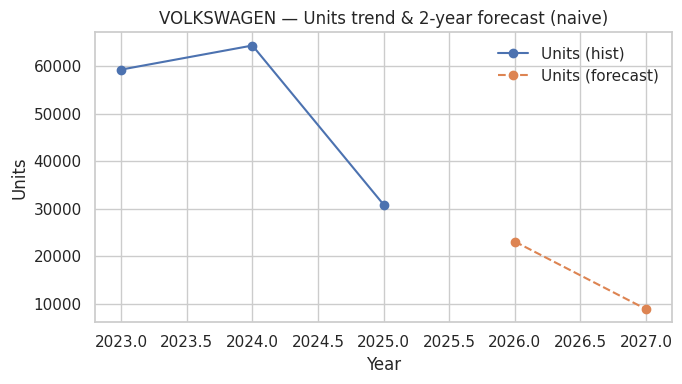

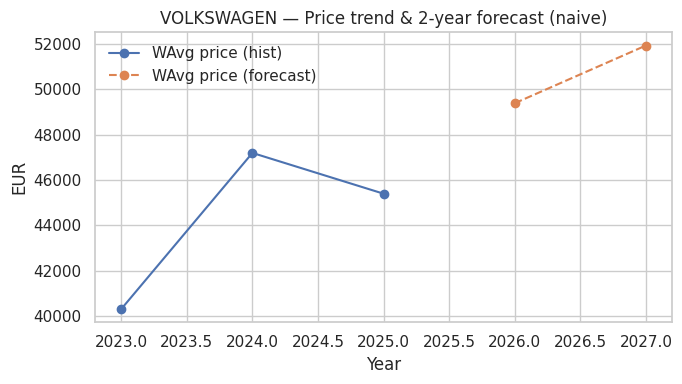

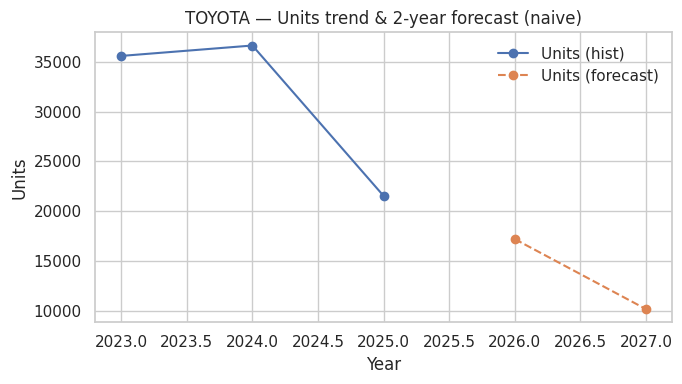

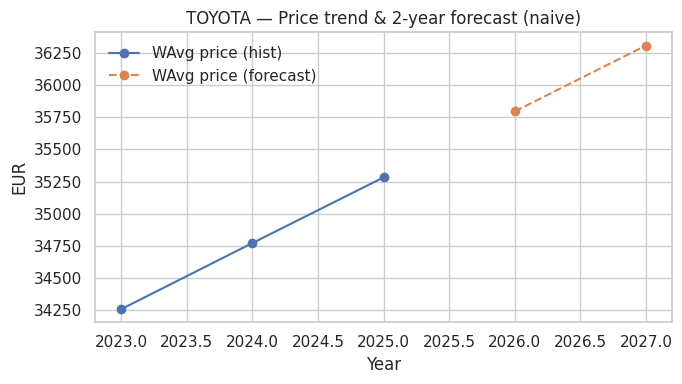

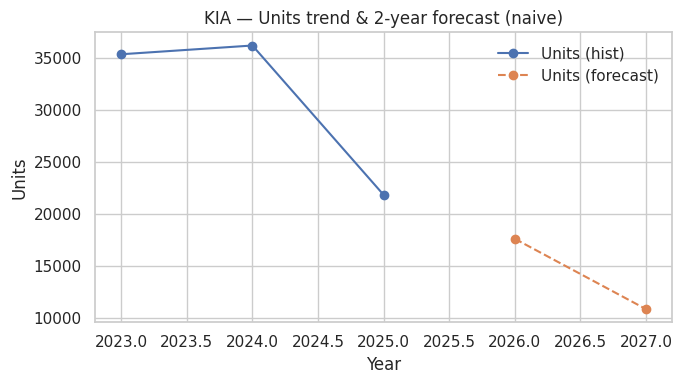

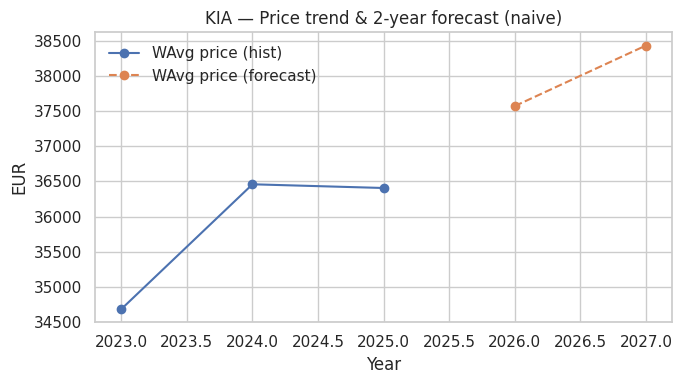

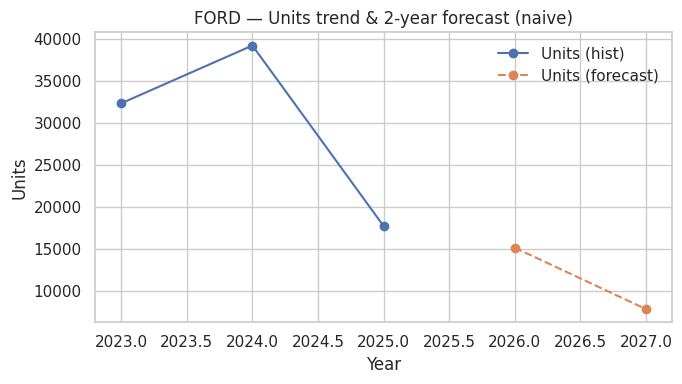

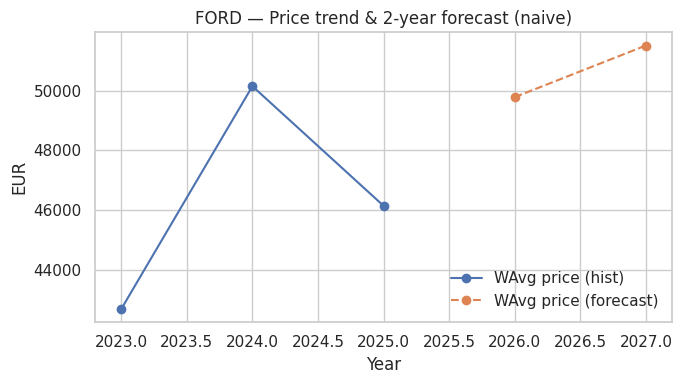

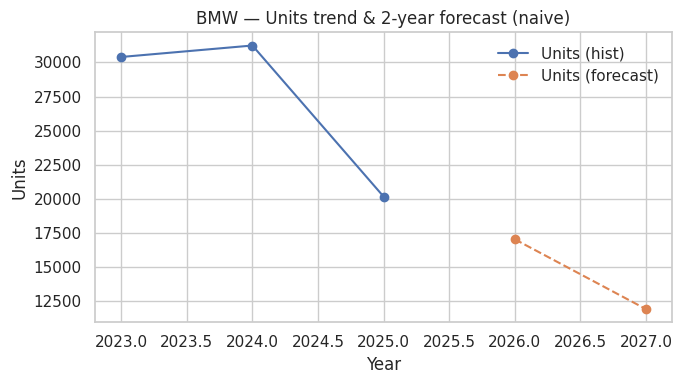

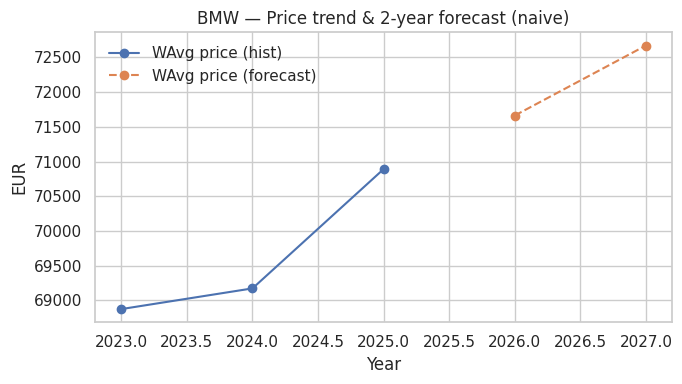

In [13]:
# Aggregate brand-level totals per year and volume-weighted brand price
brand_year_rows = []
for y in YEARS:
    c = f"count_{y}"
    p = f"avg_{y}"
    tmp = df[[ "brand","model", c, p ]].copy()
    tmp["units"] = pd.to_numeric(tmp[c], errors="coerce").fillna(0)
    tmp["price"] = pd.to_numeric(tmp[p], errors="coerce")
    for brand, g in tmp.groupby("brand"):
        total_units = g["units"].sum()
        # weighted avg price if price available; else NaN
        if g["price"].notna().any() and total_units > 0:
            wavg_price = (g["price"] * g["units"]).sum() / total_units
        else:
            wavg_price = np.nan
        brand_year_rows.append({"brand": brand, "year": y, "units": total_units, "wavg_price": wavg_price})

by = pd.DataFrame(brand_year_rows)

# Top 5 brands by total units over 2023–2025
top5 = (by.groupby("brand")["units"].sum().sort_values(ascending=False).head(5).index.tolist())
by_top = by[by["brand"].isin(top5)].copy()
display(by_top.head(10))

# Fit a simple linear trend per brand for units and price, then forecast 2026–2027
future_years = [2026, 2027]
pred_rows = []
for brand, g in by_top.groupby("brand"):
    g = g.sort_values("year")
    x = g["year"].values
    # units
    y_units = g["units"].values
    # simple linear fit (np.polyfit degree 1)
    m_u, b_u = np.polyfit(x, y_units, deg=1)
    for fy in future_years:
        pred_units = m_u * fy + b_u
        pred_rows.append({"brand": brand, "year": fy, "metric": "units", "prediction": max(0, pred_units)})

    # price (skip if too many NaNs)
    y_price = g["wavg_price"].values
    if np.isfinite(y_price).sum() >= 2:  # need at least 2 points
        valid = np.isfinite(y_price)
        m_p, b_p = np.polyfit(x[valid], y_price[valid], deg=1)
        for fy in future_years:
            pred_price = m_p * fy + b_p
            pred_rows.append({"brand": brand, "year": fy, "metric": "wavg_price", "prediction": max(0, pred_price)})

pred = pd.DataFrame(pred_rows)

# Show forecast tables
display(pred.pivot_table(index=["brand","year"], columns="metric", values="prediction"))

# Quick plots per brand
for brand in top5:
    g = by_top[by_top["brand"]==brand].sort_values("year")
    plt.figure(figsize=(7,4))
    plt.plot(g["year"], g["units"], marker="o", label="Units (hist)")
    p_u = pred[(pred["brand"]==brand) & (pred["metric"]=="units")].sort_values("year")
    if not p_u.empty:
        plt.plot(p_u["year"], p_u["prediction"], marker="o", linestyle="--", label="Units (forecast)")
    plt.title(f"{brand} — Units trend & 2-year forecast (naive)")
    plt.xlabel("Year"); plt.ylabel("Units"); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(g["year"], g["wavg_price"], marker="o", label="WAvg price (hist)")
    p_p = pred[(pred["brand"]==brand) & (pred["metric"]=="wavg_price")].sort_values("year")
    if not p_p.empty:
        plt.plot(p_p["year"], p_p["prediction"], marker="o", linestyle="--", label="WAvg price (forecast)")
    plt.title(f"{brand} — Price trend & 2-year forecast (naive)")
    plt.xlabel("Year"); plt.ylabel("EUR"); plt.legend(frameon=False)
    plt.tight_layout(); plt.show()

## Spearman correlations (put last)

Why Spearman here:

Your aggregates (brand-model medians/means) are not guaranteed normal, may have outliers, and many relationships are non-linear but monotonic.

Spearman (rank correlation) is robust to outliers & non-normality and captures monotone association (not just linear).

We keep it last as a diagnostic lens after the structured EDA.

In [14]:
corr_cols = ["avg_price","pw_ratio_median","mass_empty_median","length_median","wheelbase_median","seats_median","share_delta"]
corr_df = df[corr_cols].dropna()
spearman = corr_df.corr(method="spearman")
spearman

,avg_price,pw_ratio_median,mass_empty_median,length_median,wheelbase_median,seats_median,share_delta
avg_price,1.000000,-0.224091,0.534093,0.514133,0.498548,0.420051,0.023654
pw_ratio_median,-0.224091,1.000000,-0.815302,-0.790098,-0.803420,-0.428694,0.049527
mass_empty_median,0.534093,-0.815302,1.000000,0.960109,0.957570,0.382756,-0.024323
length_median,0.514133,-0.790098,0.960109,1.000000,0.984031,0.373685,-0.050399
wheelbase_median,0.498548,-0.803420,0.957570,0.984031,1.000000,0.386720,-0.047408
seats_median,0.420051,-0.428694,0.382756,0.373685,0.386720,1.000000,-0.043388
share_delta,0.023654,0.049527,-0.024323,-0.050399,-0.047408,-0.043388,1.000000
